In [14]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import zlib, base64
from skimage.io import imread
import cv2 as cv
import os
import re
import torch
import torchvision.transforms.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.utils import draw_segmentation_masks
import skimage
from skimage import io

import itertools

In [5]:
def load_mask(mask_path, image):
    
    #     '''

        # Creating an array of zeros for each feature type. There may be
        # multiple separate objects of the same feature type, and this
        # is how we store objects of the same feature class together.

    my_dict = {'dark': np.zeros(image.shape[:-1]).astype(bool),
               'cross': np.zeros(image.shape[:-1]).astype(bool),
               'crack': np.zeros(image.shape[:-1]).astype(bool),
               'busbar': np.zeros(image.shape[:-1]).astype(bool)}

    with open(mask_path, 'r') as file:
        data = json.load(file)
    try:
        objects = data['objects']
    except KeyError:
        objects = data['annotation']['objects']
    for obj in objects:
        code = obj["bitmap"]["data"]
        origin = obj["bitmap"]["origin"]
        z = zlib.decompress(base64.b64decode(code))
        n = np.frombuffer(z, np.uint8)
        mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)  

        # This is some unfortunate maneuvering to address the fact that
        # bitmap annotations do not usually come in the same size as the
        # image from which they were labeled, and so it is necessary to
        # situate the annotation in an otherwise empty array that is the
        # same size as the image

        mask_center = np.array([mask.shape[1]/2, mask.shape[0]/2])
        mask_center += origin
        up = np.zeros((origin[1], mask.shape[1]))
        mask2 = np.vstack((up, mask))
        left = np.zeros((mask2.shape[0], origin[0]))
        mask3 = np.hstack((left, mask2))
        down = np.zeros((image.shape[0] - mask3.shape[0], mask3.shape[1]))
        mask4 = np.vstack((mask3, down))
        right = np.zeros((mask4.shape[0], image.shape[1] - mask4.shape[1]))
        mask5 = np.hstack((mask4, right)).astype(bool) 

        # Save the data from each object in the appropriate array depending on
        # its feature type

        if 'dark' in obj['classTitle'].lower():
            my_dict['dark'] = np.logical_or(my_dict['dark'],
                                              mask5).astype(bool)
        elif 'cross' in obj['classTitle'].lower():
            my_dict['cross'] = np.logical_or(my_dict['cross'],
                                               mask5).astype(bool)
        elif 'crack' in obj['classTitle'].lower():
            my_dict['crack'] = np.logical_or(my_dict['crack'],
                                               mask5).astype(bool)
        elif 'busbar' in obj['classTitle'].lower():
            my_dict['busbar'] = np.logical_or(my_dict['busbar'],
                                                mask5).astype(bool)
        
    return my_dict

def stack_masks(my_dict, order=[2, 1, 0, 3], mapping={0 : 4,
                                                      1 : 3,
                                                      2 : 2,
                                                      3 : 1}):
    
        # Stack the four n_x by n_y feature arrays

    all_masks = torch.dstack([torch.tensor(v) for v in 
                              my_dict.values()]).permute(2, 0, 1)

    new_tensor = torch.zeros([all_masks.shape[1], all_masks.shape[2]], dtype=torch.float64)

    for i, j in itertools.product(range(image.shape[0]), range(image.shape[1])):
        
        if all_masks[order[0], i, j]:
            val = mapping[order[0]]
        elif all_masks[order[1], i, j]:
            val = mapping[order[1]]
        elif all_masks[order[2], i, j]:
            val = mapping[order[2]]
        elif all_masks[order[3], i, j]:
            val = mapping[order[3]]
        else:
            val = 0

        new_tensor[i, j] = val

    return new_tensor

In [6]:
root = '/projects/wg-psel-ml/EL_images/eccoope/' #os.path.join(os.path.expanduser("~"), 'el_img_cracks_ec', 'split_busbars')

img_folder = os.path.join(root, 'img_cropped', 'original')
mask_folder = os.path.join(root, 'ann_json')
files = [c for c in os.listdir(mask_folder) if c != '.ipynb_checkpoints']
n_masks = [re.search(r'(.+)\.jpg\.json', f).group(1) for f in files]

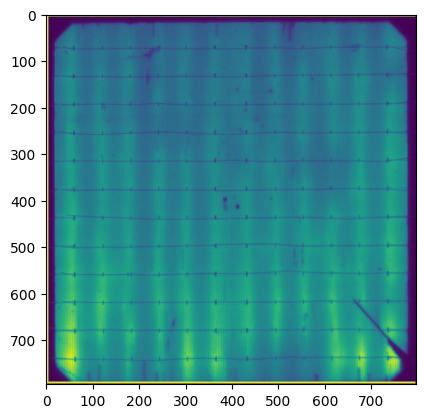

In [7]:
n = n_masks[1]
mask_path = os.path.join(mask_folder, f'{n}.jpg.json')
img_path = os.path.join(img_folder, f'{n}.jpg')
image = imread(img_path)
my_dict = load_mask(mask_path, image)
plt.imshow(image)

ORIGINAL LABELING
dark = 0
cross = 1
crack = 2
busbar = 3

NEW LABELING
none = 0
dark = 1
cross = 2
crack = 3
busbar = 4

MODEL LABELING
none = 0
busbar = 1
crack = 2
cross = 3
dark = 4

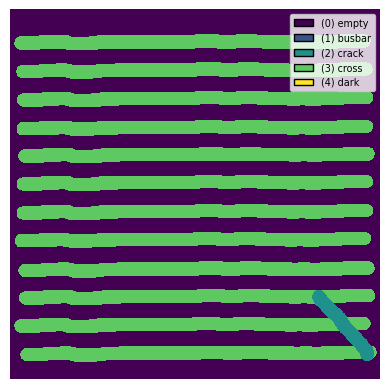

In [15]:
cracks_mask = stack_masks(my_dict, order=[2, 1, 0, 3], mapping={0 : 0,
                                                                  1 : 1,
                                                                  2 : 2,
                                                                  3 : 3})
my_map = {0 : 'empty',
          1 : 'busbar',
          2 : 'crack',
          3 : 'cross',
          4 : 'dark'}

fig, ax = plt.subplots()

clim = (0, 4)
ax.imshow(cracks_mask, clim=clim, interpolation='None')

# Do legend
cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
cmaplist = [cmap(i) for i in range(5)]
handles, labels = ax.get_legend_handles_labels()
for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in my_map.items()]):
        patch = mpatches.Patch(color=c, label=classlabel, ec='k')
        handles.append(patch)
ax.legend(handles=handles, fontsize='x-small')

ax.axis('off');

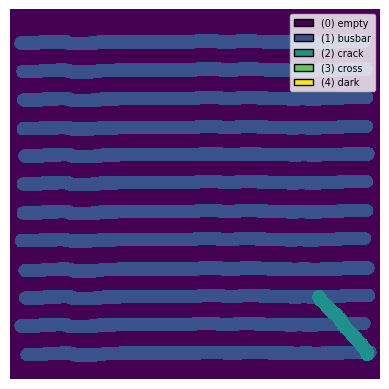

In [16]:
cracks_mask = stack_masks(my_dict, order=[2, 1, 0, 3], mapping={0 : 4,
                                                                  1 : 3,
                                                                  2 : 2,
                                                                  3 : 1})
my_map = {0 : 'empty',
          1 : 'busbar',
          2 : 'crack',
          3 : 'cross',
          4 : 'dark'}

fig, ax = plt.subplots()
clim = (0, 4)
ax.imshow(cracks_mask, clim=clim, interpolation='None')
cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
cmaplist = [cmap(i) for i in range(5)]
handles, labels = ax.get_legend_handles_labels()

for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in my_map.items()]):
        patch = mpatches.Patch(color=c, label=classlabel, ec='k')
        handles.append(patch)
ax.legend(handles=handles, fontsize='x-small')
ax.axis('off');

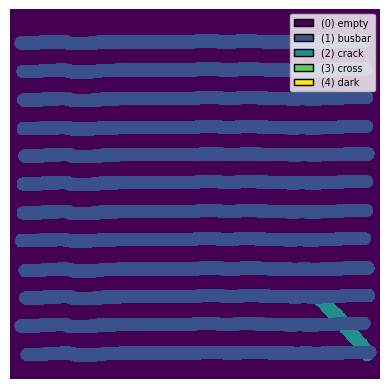

In [17]:
busbars_mask = stack_masks(my_dict, order=[3, 1, 0, 2])

my_map = {0 : 'empty',
          1 : 'busbar',
          2 : 'crack',
          3 : 'cross',
          4 : 'dark'}

fig, ax = plt.subplots()
clim = (0, 4)
ax.imshow(busbars_mask, clim=clim, interpolation='None')
cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
cmaplist = [cmap(i) for i in range(5)]
handles, labels = ax.get_legend_handles_labels()

for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in my_map.items()]):
        patch = mpatches.Patch(color=c, label=classlabel, ec='k')
        handles.append(patch)
ax.legend(handles=handles, fontsize='x-small')
ax.axis('off');

In [18]:
for n in n_masks:
    mask_path = os.path.join(mask_folder, f'{n}.jpg.json')
    img_path = os.path.join(img_folder, f'{n}.jpg')
    try:
        image = imread(img_path)
        my_dict = load_mask(mask_path, image)
        save_dir_busbars = os.path.join(root, 'ann_npy_split_busbars', 'original', f'{n}.npy')
        save_dir_cracks = os.path.join(root, 'ann_npy_split_cracks', 'original', f'{n}.npy')
        
        busbars_mask = stack_masks(my_dict, order=[3, 1, 0, 2])
        cracks_mask = stack_masks(my_dict, order=[2, 1, 0, 3])
        
        np.save(save_dir_busbars, busbars_mask)
        np.save(save_dir_cracks, cracks_mask)
    except:
        print(n)
        continue

486 - Module 4 (EL Image)
516 - TOPCon_3_front_post (EL Image)
511 - TOPCon_1_front_post (EL Image)
512 - TOPCon_1_front_post_2 (EL Image)
